In [120]:
import sys
sys.path.append("../../")
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
import plotly.express as px
from functions.eda import *
from functions.cat_eda import *
from functions.basic_cleaning import *
from functions.num_eda import *
from functions.pipeline_helpers import *

In [121]:
data = pl.read_csv("Ice Cream Sales - temperatures.csv")
data

Temperature,Ice Cream Profits
i64,f64
39,13.17
40,11.88
41,18.82
42,18.65
43,17.02
…,…
99,85.13
99,87.08
99,89.29


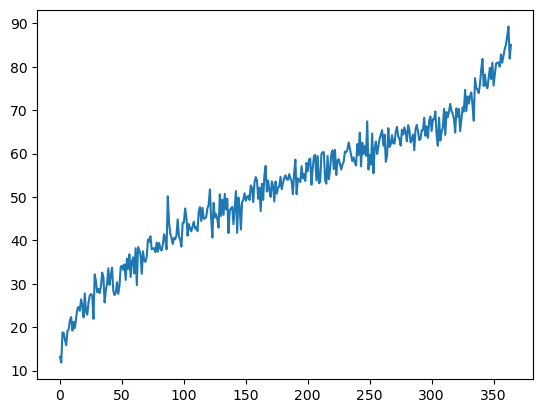

In [122]:
plt.plot(data['Ice Cream Profits'])

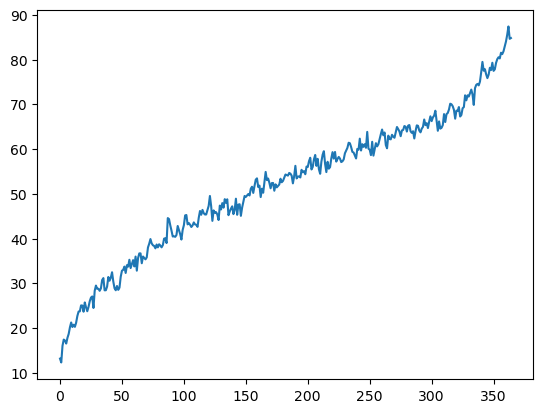

In [123]:
plt.plot(data['Ice Cream Profits'].ewm_mean(alpha=.5))

In [124]:
data=data[1:].with_columns(pl.Series(data['Ice Cream Profits'][1:]-data['Ice Cream Profits'][:-1]).alias('lag1'))
# data=data[1:].with_columns(data['Ice Cream Profits'].ewm_mean(com=.9).alias('ema'))
# data=data.with_columns(pl.Series(data['Ice Cream Profits'].rolling_mean(5)).alias('moving Avg'))
# data=data[1:].with_columns(pl.Series(data['moving Avg'][1:]-data['moving Avg'][:-1]).alias('lag2'))

In [125]:
data

Temperature,Ice Cream Profits,lag1
i64,f64,f64
40,11.88,-1.29
41,18.82,6.94
42,18.65,-0.17
43,17.02,-1.63
43,15.88,-1.14
…,…,…
99,85.13,1.01
99,87.08,1.95
99,89.29,2.21


In [126]:
data=data.drop_nulls()

<Axes: ylabel='Count'>

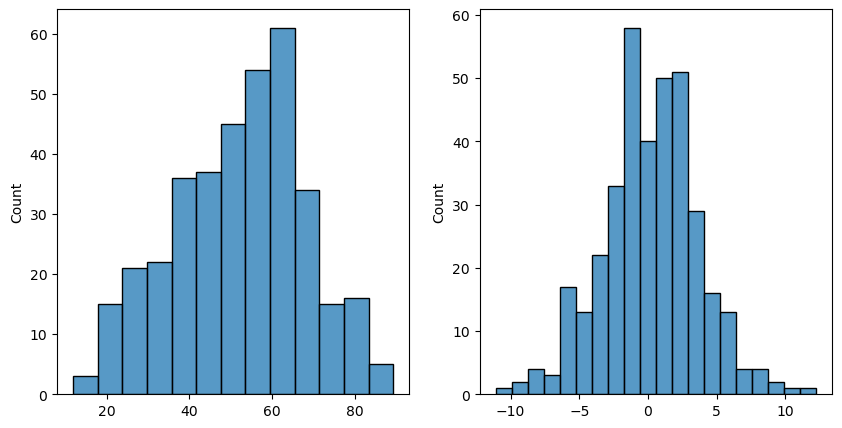

In [127]:
fig,[ax1,ax2] = plt.subplots(ncols=2,figsize=(10,5))
sns.histplot(data['Ice Cream Profits'],ax=ax1)
sns.histplot(data['lag1'],ax=ax2)

<Axes: xlabel='Temperature', ylabel='lag1'>

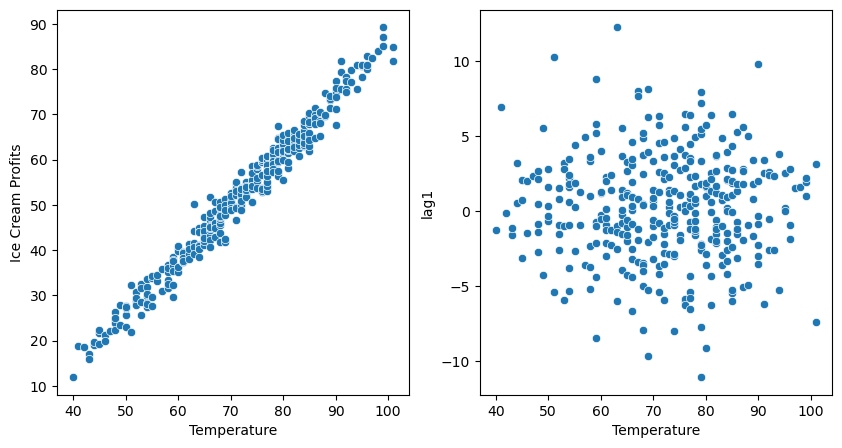

In [128]:
fig,[ax1,ax2] = plt.subplots(ncols=2,figsize=(10,5))
sns.scatterplot(x=data['Temperature'],y=data['Ice Cream Profits'],ax=ax1)
sns.scatterplot(x=data['Temperature'],y=data['lag1'],ax=ax2)

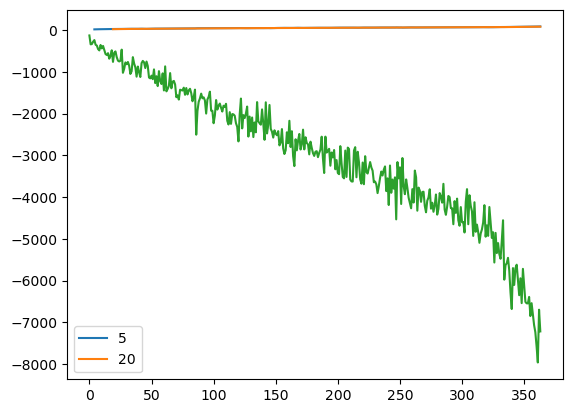

In [153]:
plt.plot(data['Ice Cream Profits'].rolling_mean(window_size=5))
plt.plot(data['Ice Cream Profits'].rolling_mean(window_size=20))
plt.legend(['5','20'])

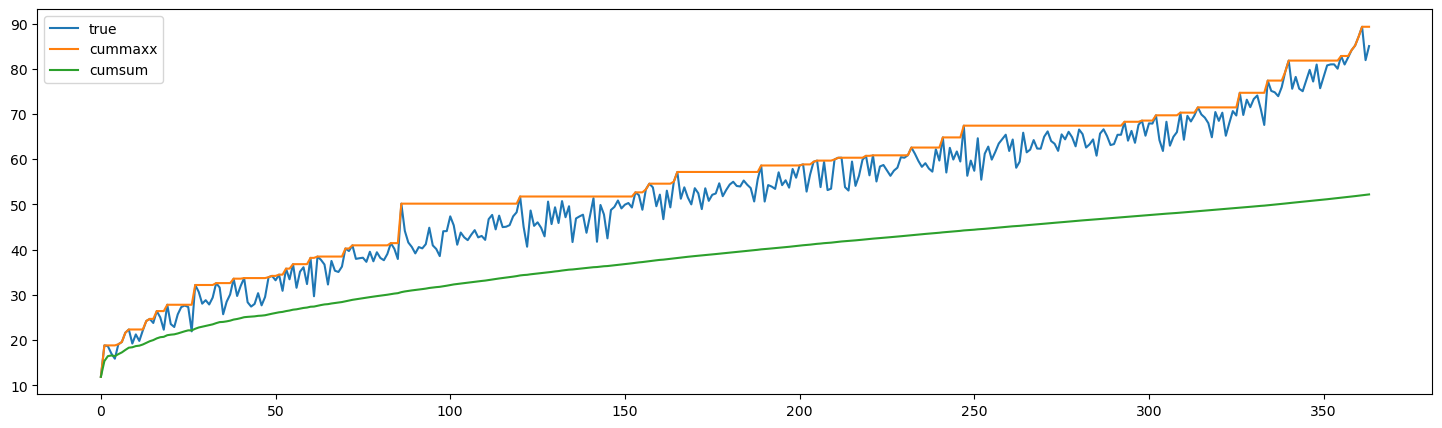

In [177]:
plt.figure(figsize=(18,5))
plt.plot(data['Ice Cream Profits'])
plt.plot(data['Ice Cream Profits'].cum_max())
plt.plot(data['Ice Cream Profits'].cum_sum()/np.arange(1,365))
plt.legend(['true','cummaxx','cumsum'])

In [184]:
np.corrcoef(data['Ice Cream Profits'],data['Ice Cream Profits'].shift_and_fill(0,n=1))

array([[1.        , 0.97533557],
       [0.97533557, 1.        ]])

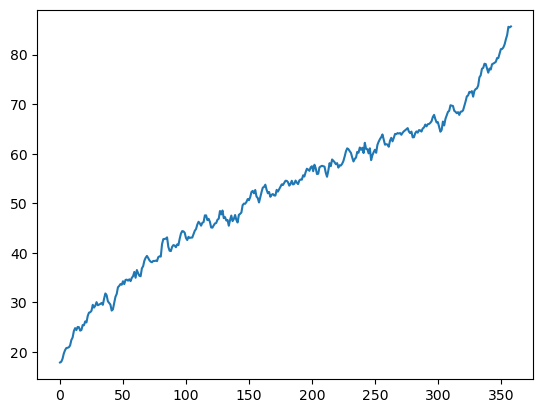

In [57]:
plt.plot(data['moving Avg'])

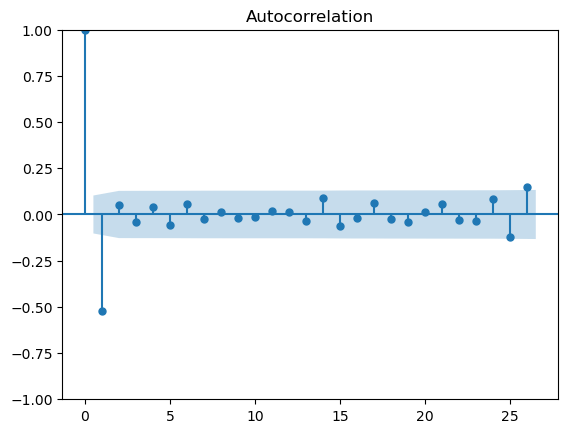

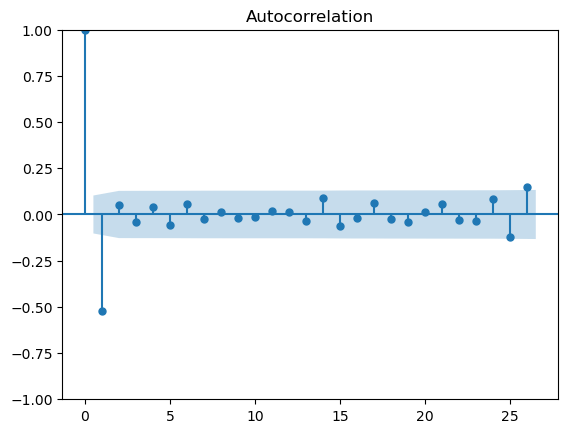

In [187]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(x=data['lag1'])

In [188]:
train_data = data.filter(data['Temperature']<90)
test_data = data.filter(data['Temperature']>90)
train_data.shape,test_data.shape

((332, 3), (25, 3))

In [199]:
model = ARIMA(train_data['Ice Cream Profits'].to_pandas(),order=(0,0,1))
model_fit  = model.fit()

In [200]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      Ice Cream Profits   No. Observations:                  332
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1196.006
Date:                Tue, 25 Jun 2024   AIC                           2398.011
Time:                        00:08:46   BIC                           2409.427
Sample:                             0   HQIC                          2402.564
                                - 332                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.5859      0.921     53.861      0.000      47.781      51.390
ma.L1          0.7681      0.037     20.819      0.000       0.696       0.840
sigma2        78.5925      7.201     10.914      0.000      64.479      92.706
===================================================================================
Ljung-Box (L1) (Q):                 117.81   Jarque-Bera (JB):                 7.88
Prob(Q):                              0.00   Prob(JB):                         0.02
Heteroskedasticity (H):               0.79   Skew:                            -0.31
Prob(H) (two-sided):                  0.21   Kurtosis:                         2.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [201]:
pred=model_fit.predict(start=90,end=101)

In [202]:
pred=model_fit.predict(start=330,end=365)

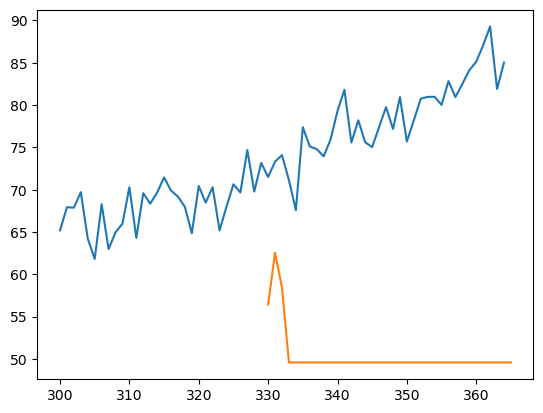

In [203]:
plt.plot(data['Ice Cream Profits'][300:])
plt.plot(pred)